### Mount Drive

In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
import os
# The path below should point to the directory containing this notebook and 
# the associated utility files
os.chdir('drive/MyDrive/Colab Notebooks/FourthBrain/data/')
!ls

### Load Data

In [4]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.parse import urlparse

In [5]:
# load data 
df = pd.read_csv('df_complete.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Preprocess Data

In [6]:
# drop samples without pageview history
pageviews = df.drop(list(np.ravel(np.where(
    df['url0'] == 0 
    ))))

# drop useless column
pageviews = pageviews.drop(columns='Unnamed: 0')

In [7]:
cols2drop = [
 'Became a Lead Date',
 'Became a Subscriber Date',
 'Became an Opportunity Date',
 'First Conversion Date',
 'First marketing email click date',
 'First marketing email open date',
 'First marketing email send date',
 'Last Activity Date',
 'Last marketing email click date',
 'Last marketing email name',
 'Last marketing email open date',
 'Last marketing email send date',
 'First Page Seen',
 'Last Page Seen',
 'Marketing emails opened',
 'Marketing emails delivered',
 'Marketing emails clicked',
 'Opted out of email: Events and Community',
 'Opted out of email: Program Announcements',
 'Opted out of email: The Batch',
 'Unsubscribed from all email',
 'Which of the following online courses have you taken from deeplearning.ai?',
 'Last Registered Event',
 'Last Registered Event Date',
 'Number of event completions',
 'Highest level of completed education',
 'Job Title or Function',
 'IP Country Code',
 'Associated Company ID',]

# drop columns and store in X
X = pageviews.drop(columns=cols2drop)

In [8]:
# create dictionary of country encodings 
countries = dict(zip(X['IP Country'].unique(), list(range(len(X)))))

# map encodings to X
X['IP Country'] = X['IP Country'].map(countries)

In [9]:
# create column identifying paid learners where
# (purchase = 1) and (non-purchase = 0)
r,m = np.where(X.iloc[:, 5:9] == 6)
X['purchase'] = 0
X['purchase'].iloc[r] = 1

In [10]:
# display percentage of "purchase" within the data set
X['purchase'].value_counts(normalize=True)

0    0.852078
1    0.147922
Name: purchase, dtype: float64

In [11]:
# sanity check
X.iloc[np.where(X['purchase']==1)]

,Contact ID,Average Pageviews,Number of Pageviews,Number of Sessions,IP Country,url0,url1,url2,url3,purchase
82,2354,1,5,3,6,6,7,3,0,1
92,233,3,7,2,0,6,7,1,4,1
233,1239,1,1,1,6,6,0,0,0,1
264,2150,1,6,4,14,6,2,3,6,1
358,1123,5,5,1,18,6,3,6,3,1
...,...,...,...,...,...,...,...,...,...,...
324915,52997151,4,4,1,6,6,7,5,0,1
324919,53015251,2,5,2,67,6,4,2,0,1
324924,53047151,1,4,3,56,6,7,0,0,1
324961,53209701,1,9,5,6,6,7,5,3,1


In [12]:
# save to csv 
X.to_csv('urls_encoded.csv')

### Create new columns for purchase year, months and day.

In [13]:
# load data
pageview_hist = pd.read_csv('pageview_hist.csv', encoding='utf-8').fillna(0)

# collect indices of rows with purchase = 1
c1 = X['Contact ID'].iloc[np.ravel(np.where(X['url0']==6))].astype('int64')
c2 = X['Contact ID'].iloc[np.ravel(np.where(X['url1']==6))].astype('int64')
c3 = X['Contact ID'].iloc[np.ravel(np.where(X['url2']==6))].astype('int64')
c4 = X['Contact ID'].iloc[np.ravel(np.where(X['url3']==6))].astype('int64')

contacts = [c1, c2, c3, c4]
# locate index pairings between contacts and pageview_hist
l1 = []
for i in contacts:
  loc = [np.where((pageview_hist['Contact ID'] == i) == True) \
         for i in i.to_list()]

  l1.append(loc)

locations = l1[0] + l1[1] + l1[2] + l1[3]

In [14]:
df = pageview_hist.iloc[np.ravel(locations).tolist()]

df1 = df['Last Page Seen Change Date'].str.split(expand=True)
df2 = df1[0].str.split(expand=True)
df3 = df2[0].str.split('-', expand=True)

rl = [np.where((X['Contact ID'] == i) == True) for i in\
      pageview_hist['Contact ID'].iloc[df3.index].to_list()]

X['year'] = 0
X['month'] = 0
X['day'] = 0

X['year'].iloc[np.ravel(rl).tolist()] = df3[0]
X['month'].iloc[np.ravel(rl).tolist()] = df3[1]
X['day'].iloc[np.ravel(rl).tolist()] = df3[2]

X.iloc[np.where(X['purchase'] == 1)]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Contact ID,Average Pageviews,Number of Pageviews,Number of Sessions,IP Country,url0,url1,url2,url3,purchase,year,month,day
82,2354,1,5,3,6,6,7,3,0,1,2020,09,30
92,233,3,7,2,0,6,7,1,4,1,2020,09,29
233,1239,1,1,1,6,6,0,0,0,1,2020,09,28
264,2150,1,6,4,14,6,2,3,6,1,2020,06,19
358,1123,5,5,1,18,6,3,6,3,1,2019,12,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
324915,52997151,4,4,1,6,6,7,5,0,1,2020,11,13
324919,53015251,2,5,2,67,6,4,2,0,1,2020,11,13
324924,53047151,1,4,3,56,6,7,0,0,1,2020,11,13
324961,53209701,1,9,5,6,6,7,5,3,1,2020,11,16


In [15]:
df = pageview_hist.iloc[np.ravel(locations).tolist()]

df1 = df['Last Page Seen Change Date']

rl = [np.where((X['Contact ID'] == i) == True) for i in\
      pageview_hist['Contact ID'].iloc[df1.index].to_list()]

X['event_time'] = 0

X['event_time'].iloc[np.ravel(rl).tolist()] = df1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [16]:
# get list of columns
cols = X.columns.tolist()
# move last element to front position
cols = cols[-1:] + cols[:-1]
# store reorganized and encoded array in train
train = X[cols]
# convert column event_time from object to datetime
#train['event_time'] = train['event_time'].astype('datetime64[ns]')
# convert column year from object to datetime
train['year'] = train['year'].astype('int64')
# convert column month from object to datetime
train['month'] = train['month'].astype('int64')
# convert column day from object to datetime
train['day'] = train['day'].astype('int64')
# check dtypes of train
train.info()

# save file
train.to_csv('train.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90345 entries, 5 to 325021
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   event_time           90345 non-null  object
 1   Contact ID           90345 non-null  int64 
 2   Average Pageviews    90345 non-null  int64 
 3   Number of Pageviews  90345 non-null  int64 
 4   Number of Sessions   90345 non-null  int64 
 5   IP Country           90345 non-null  int64 
 6   url0                 90345 non-null  int64 
 7   url1                 90345 non-null  int64 
 8   url2                 90345 non-null  int64 
 9   url3                 90345 non-null  int64 
 10  purchase             90345 non-null  int64 
 11  year                 90345 non-null  int64 
 12  month                90345 non-null  int64 
 13  day                  90345 non-null  int64 
dtypes: int64(13), object(1)
memory usage: 10.3+ MB


### Prepare sequence data

In [17]:
# list column names to aid arrangement selection of features
cols = ['event_time','Contact ID','Average Pageviews','Number of Pageviews',
 'Number of Sessions','IP Country','url0','url1','url2','url3','year',
 'month','day','purchase',]

# find event times that aren't zero 
non_zeros = train['event_time'].iloc[np.where(train['event_time'] != 0)].astype('datetime64[ns]')
# store the event times in new column "event_time"
train['event_time'] = non_zeros 
# replace NaNs with 0s
train = train.fillna(0)

# sanity check
train.iloc[np.where(train['event_time']!=0)].sort_values('event_time').head(3)

,event_time,Contact ID,Average Pageviews,Number of Pageviews,Number of Sessions,IP Country,url0,url1,url2,url3,purchase,year,month,day
75073,2019-08-14 05:42:00,202025,2,5,2,8,4,3,6,3,1,2019,8,14
96600,2019-08-14 19:28:00,228989,2,2,1,22,6,3,0,0,1,2019,8,14
27356,2019-08-14 19:31:00,99062,7,7,1,6,6,14,4,8,1,2019,8,14


In [18]:
# colate url sequences by user
sequences = []

for i in range(len(train)):
  sequences.append([train['url0'].iloc[i], train['url1'].iloc[i], 
                    train['url2'].iloc[i], train['url3'].iloc[i]]
                   )
# sanity check
sequences[:5]

[[1, 3, 0, 0], [2, 3, 0, 0], [3, 0, 0, 0], [3, 0, 0, 0], [4, 0, 0, 0]]

In [19]:
# sequences containing zeros
zeros = list(filter(lambda x: 0 in x[1], enumerate(sequences)))

# updata data with new sequences
train['sequence'] = sequences

# create array of events
event = np.array((train['sequence'].to_list())).astype('int64')

# one hot encode the purchase labels
y = np.array(pd.get_dummies(train['purchase']))
z = np.sum(y[:,1])/len(y)
print("Percentage of purchase sessions:", z*100)

Percentage of purchase sessions: 14.792185511096353


In [24]:
# perform 70/30 split
from sklearn.model_selection import train_test_split

def prepare_train_test_data(data,y):
  #input is data[nxd] and Y[nx2], outputs 70/30 split formatted for the sequence models
  X_train, X_test, y_train, y_test = train_test_split(data, y,                              
                                                    test_size=0.3)
  #Resizing is necessary since input to sequence models is (1,d)
  X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
  X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
  return (X_train,X_test,y_train,y_test)  

xtrain, xtest, ytrain, ytest = prepare_train_test_data(event, y)
print(xtrain.shape, ytrain.shape)

(63241, 1, 4) (63241, 2)


### Model Assembly

In [29]:
# Helper functions...
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ...for calculating metrics
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

def plot_history(history):
  # This function will plot the model fit process
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('acc')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


def evaluate_on_test(X_test, y_test, training_model):
  #This function will evaluate the fit model on test data
  g_preds=training_model.predict_classes(X_test)
  gaccuracy = accuracy_score(y_test[:,1], g_preds)
  print('Accuracy: %f' % gaccuracy)
  # precision tp / (tp + fp)
  gprecision = precision_score(y_test[:,1], g_preds)
  print('Precision: %f' % gprecision)
  # recall: tp / (tp + fn)
  grecall = recall_score(y_test[:,1], g_preds)
  print('Recall: %f' % grecall)
  # f1: 2 tp / (2 tp + fp + fn)
  gf1 = f1_score(y_test[:,1], g_preds)
  print('F1 score: %f' % gf1)

In [32]:
from tensorflow.keras.layers import GRU
from keras.layers import Dense, LSTM, Bidirectional
from keras.models import Sequential

def LSTM_model(neurons=40, op=10):
  model = Sequential()
  model.add(Bidirectional(LSTM(neurons, return_sequences=True), input_shape=(1,op)))
  model.add(GRU(neurons, return_sequences=True))
  model.add(Bidirectional(LSTM(2*neurons)))
  model.add(Dense(2, activation='softmax'))
  model.compile(
      optimizer=tf.optimizers.Adam(learning_rate=1e-3),
      loss='binary_crossentropy',
      metrics=['acc'])
  return model

In [33]:
tf.keras.backend.clear_session()
training_model = LSTM_model(neurons=40, op=4)
training_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 80)             14400     
_________________________________________________________________
gru (GRU)                    (None, 1, 40)             14640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 160)               77440     
_________________________________________________________________
dense (Dense)                (None, 2)                 322       
Total params: 106,802
Trainable params: 106,802
Non-trainable params: 0
_________________________________________________________________


In [34]:
l_history = training_model.fit(xtrain, ytrain,
                               epochs=100,
                               batch_size=3000,
                               validation_split=0.2)

Epoch 1/100
17/17 [==============================] - 11s 216ms/step - loss: 0.6771 - acc: 0.7157 - val_loss: 0.5918 - val_acc: 0.8540
Epoch 2/100
17/17 [==============================] - 2s 102ms/step - loss: 0.5435 - acc: 0.8506 - val_loss: 0.4063 - val_acc: 0.8540
Epoch 3/100
17/17 [==============================] - 2s 113ms/step - loss: 0.3859 - acc: 0.8536 - val_loss: 0.3409 - val_acc: 0.8601
Epoch 4/100
17/17 [==============================] - 2s 102ms/step - loss: 0.3353 - acc: 0.8602 - val_loss: 0.3205 - val_acc: 0.8640
Epoch 5/100
17/17 [==============================] - 2s 103ms/step - loss: 0.3173 - acc: 0.8638 - val_loss: 0.3014 - val_acc: 0.8671
Epoch 6/100
17/17 [==============================] - 2s 103ms/step - loss: 0.3014 - acc: 0.8627 - val_loss: 0.2850 - val_acc: 0.8705
Epoch 7/100
17/17 [==============================] - 2s 103ms/step - loss: 0.2810 - acc: 0.8796 - val_loss: 0.2703 - val_acc: 0.8793
Epoch 8/100
17/17 [==============================] - 2s 103ms/step -

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


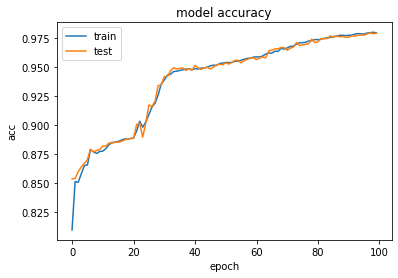

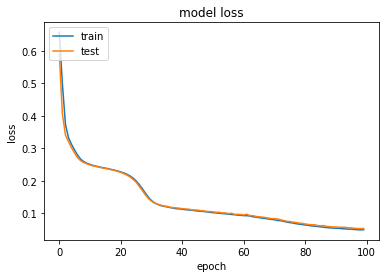

In [35]:
plot_history(l_history)

In [36]:
evaluate_on_test(xtest, ytest, training_model)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.978343
Precision: 0.952331
Recall: 0.898326
F1 score: 0.924540
